In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("merged_transactions_feedback.csv")

customer_df = df.groupby("Customer_ID").agg({
    "Transaction_Amount": "sum",
    "Satisfaction_Score": "mean",
    "Likelihood_to_Recommend": "mean",
    "Transaction_ID": "count"
}).reset_index()

customer_df.rename(columns={
    "Transaction_Amount": "Total_Transaction_Amount",
    "Transaction_ID": "Transaction_Count",
    "Satisfaction_Score": "Avg_Satisfaction_Score",
    "Likelihood_to_Recommend": "Avg_Likelihood_to_Recommend"
}, inplace=True)

customer_df["Log_Total_Transaction_Amount"] = np.log1p(customer_df["Total_Transaction_Amount"])

customer_df.head()

,Customer_ID,Total_Transaction_Amount,Avg_Satisfaction_Score,Avg_Likelihood_to_Recommend,Transaction_Count,Log_Total_Transaction_Amount
0,1,33672.0,8.500000,9.000000,12,10.424452
1,2,14721.0,4.333333,5.000000,6,9.597098
2,3,4614.0,8.333333,3.666667,3,8.437067
3,4,49770.0,5.500000,3.333333,12,10.815188
4,5,133182.0,6.444444,5.666667,45,11.799479


In [2]:
p33 = customer_df["Total_Transaction_Amount"].quantile(0.33)
p66 = customer_df["Total_Transaction_Amount"].quantile(0.66)

def income_group(x):
    if x <= p33:
        return "Low"
    elif x <= p66:
        return "Middle"
    else:
        return "High"

customer_df["Income_Level_Group"] = customer_df["Total_Transaction_Amount"].apply(income_group)

customer_df["Income_Level_Group"].value_counts()

Income_Level_Group
High      338
Low       328
Middle    327
Name: count, dtype: int64

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = [
    "Log_Total_Transaction_Amount",   # use LOG here
    "Avg_Satisfaction_Score",
    "Avg_Likelihood_to_Recommend",
    "Transaction_Count"
]

X = customer_df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_df["Cluster"] = kmeans.fit_predict(X_scaled)

pd.crosstab(customer_df["Cluster"], customer_df["Income_Level_Group"])

/lib/python3.13/site-packages/threadpoolctl.py:1123: RuntimeWarning: JsProxy.as_object_map() is deprecated. Use as_py_json() instead.
  for filepath in LDSO.loadedLibsByName.as_object_map():


Income_Level_Group,High,Low,Middle
Cluster,,,
0,32,194,179
1,31,134,122
2,275,0,26


In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
customer_df["Cluster"] = kmeans.fit_predict(X_scaled)

customer_df.head()

,Customer_ID,Total_Transaction_Amount,Avg_Satisfaction_Score,Avg_Likelihood_to_Recommend,Transaction_Count,Log_Total_Transaction_Amount,Income_Level_Group,Cluster
0,1,33672.0,8.500000,9.000000,12,10.424452,Low,0
1,2,14721.0,4.333333,5.000000,6,9.597098,Low,2
2,3,4614.0,8.333333,3.666667,3,8.437067,Low,2
3,4,49770.0,5.500000,3.333333,12,10.815188,Middle,2
4,5,133182.0,6.444444,5.666667,45,11.799479,High,1


In [5]:
pd.crosstab(customer_df["Cluster"], customer_df["Income_Level_Group"])

Income_Level_Group,High,Low,Middle
Cluster,,,
0,35,192,182
1,273,0,23
2,30,136,122


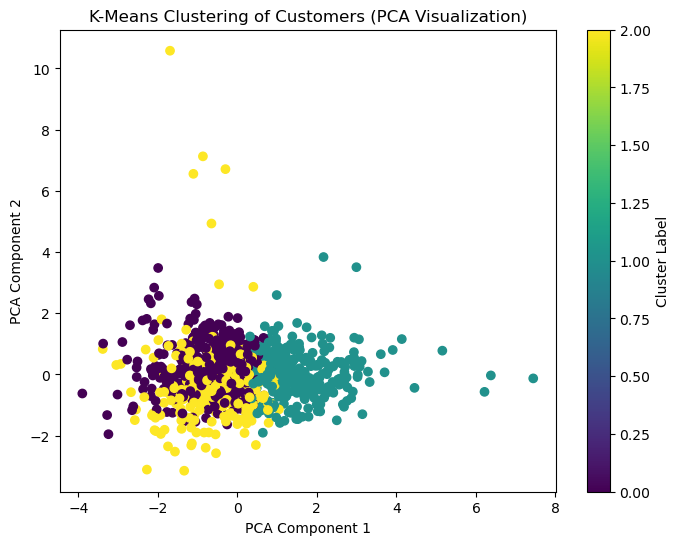

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=customer_df["Cluster"], cmap='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering of Customers (PCA Visualization)")
plt.colorbar(label="Cluster Label")
plt.show()

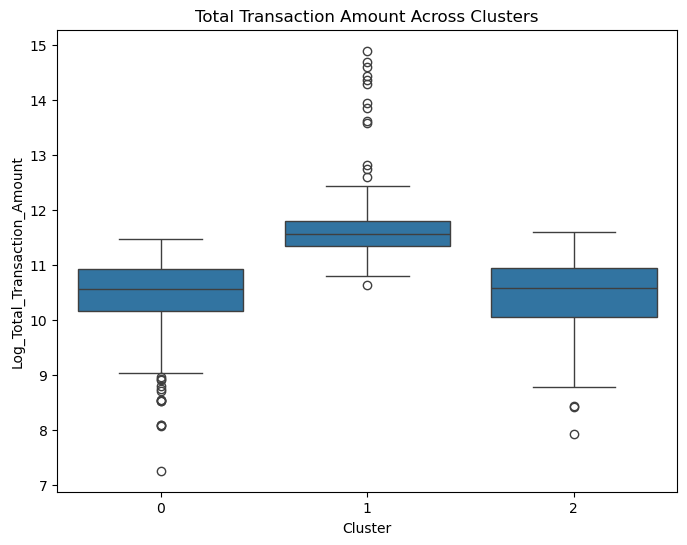

In [11]:
import micropip
await micropip.install("seaborn")
import seaborn as sns
plt.figure(figsize=(8,6))
sns.boxplot(x="Cluster", y="Log_Total_Transaction_Amount", data=customer_df)
plt.title("Total Transaction Amount Across Clusters")
plt.show()

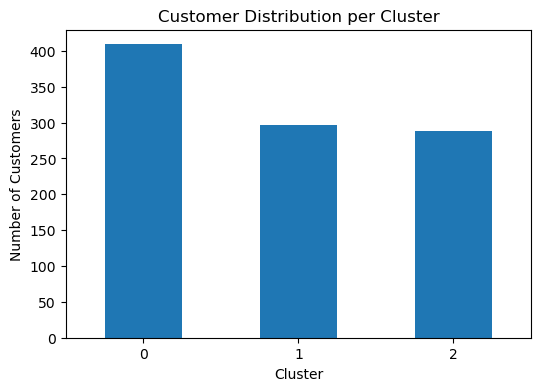

In [12]:
plt.figure(figsize=(6,4))
customer_df["Cluster"].value_counts().sort_index().plot(kind="bar")

plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution per Cluster")
plt.xticks(rotation=0)
plt.show()

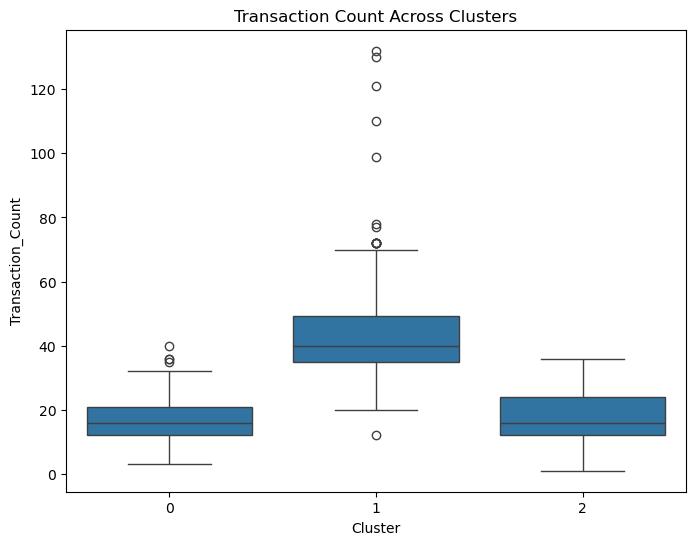

In [13]:
plt.figure(figsize=(8,6))
sns.boxplot(x="Cluster", y="Transaction_Count", data=customer_df)

plt.title("Transaction Count Across Clusters")
plt.show()

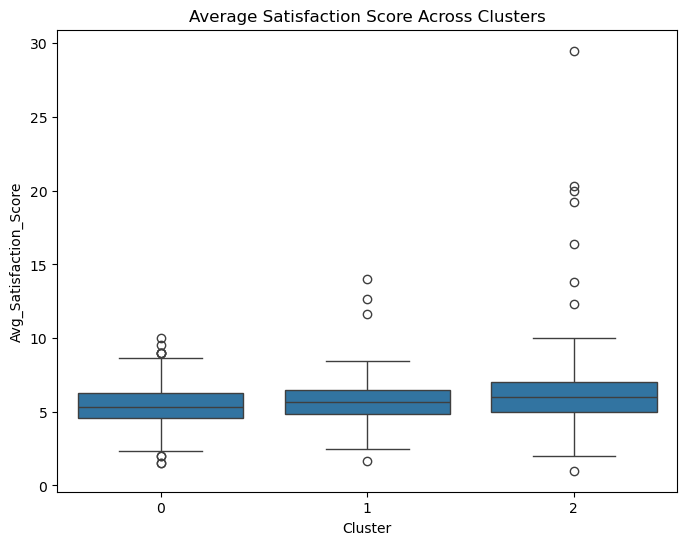

In [14]:
plt.figure(figsize=(8,6))
sns.boxplot(x="Cluster", y="Avg_Satisfaction_Score", data=customer_df)

plt.title("Average Satisfaction Score Across Clusters")
plt.show()

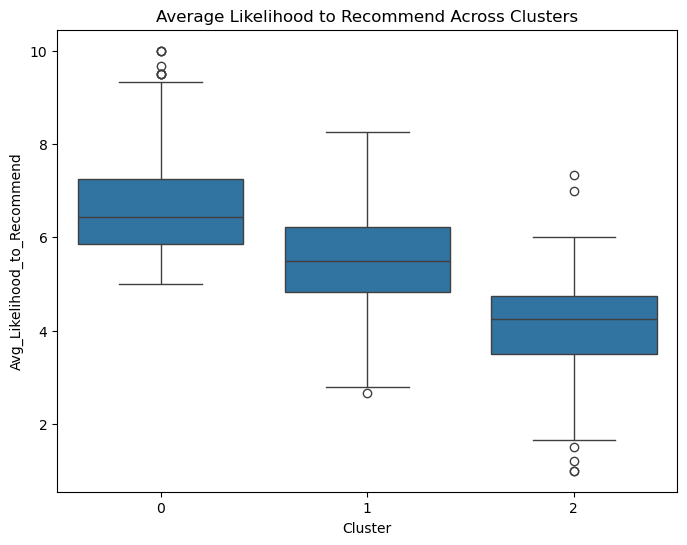

In [15]:
plt.figure(figsize=(8,6))
sns.boxplot(x="Cluster", y="Avg_Likelihood_to_Recommend", data=customer_df)

plt.title("Average Likelihood to Recommend Across Clusters")
plt.show()

In [16]:
from scipy.stats import f_oneway

# Separate clusters
cluster0 = customer_df[customer_df["Cluster"] == 0]
cluster1 = customer_df[customer_df["Cluster"] == 1]
cluster2 = customer_df[customer_df["Cluster"] == 2]

variables = [
    "Log_Total_Transaction_Amount",
    "Transaction_Count",
    "Avg_Satisfaction_Score",
    "Avg_Likelihood_to_Recommend"
]

results = {}

for var in variables:
    f_stat, p_value = f_oneway(cluster0[var], cluster1[var], cluster2[var])
    results[var] = (f_stat, p_value)

results

{'Log_Total_Transaction_Amount': (np.float64(394.3691128341936),
  np.float64(1.0813402514321835e-126)),
 'Transaction_Count': (np.float64(705.1614600834604),
  np.float64(4.035837019719544e-191)),
 'Avg_Satisfaction_Score': (np.float64(14.366992159312273),
  np.float64(7.068515305172581e-07)),
 'Avg_Likelihood_to_Recommend': (np.float64(560.2995879180041),
  np.float64(1.8137107976320955e-163))}